In [2]:
import numpy as np
import pandas as pd

# PyTorch stuff we'll need
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

## Learning Rate Scheduler

In [3]:
# model and optimizer
model = nn.Sequential(nn.Linear(2, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))
optimizer = optim.Adam(model.parameters(), lr = 0.001)

We can group the parameters of our model into different groups (will be used for transfer learning later)
- here we only have one group
- note the learning rate

In [4]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[-0.3233,  0.4921],
           [ 0.6531,  0.4330],
           [-0.2208, -0.1318],
           [-0.6808, -0.2274],
           [-0.3009, -0.1120]], requires_grad=True),
   Parameter containing:
   tensor([ 0.2859, -0.1742, -0.5774,  0.6067, -0.5640], requires_grad=True),
   Parameter containing:
   tensor([[ 0.2838,  0.3562, -0.4367, -0.2807, -0.0999]], requires_grad=True),
   Parameter containing:
   tensor([-0.1702], requires_grad=True)],
  'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False}]

The learning rate scheduler lets us adjust the learning rate according to different schemes
- For example the following is [Cosine Annealing](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) set for 100 iterations

In [6]:
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

In [7]:
# why do you think we are getting an error here?
print(optimizer.param_groups[0]['lr'])
lr_scheduler.step()
print(optimizer.param_groups[0]['lr'])

0.001
0.0009997532801828658


/Users/mruddy/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [8]:
for i in range (10):
    lr_scheduler.step()
    print(optimizer.param_groups[0]['lr'])

0.0009990133642141358
0.00099778098230154
0.000996057350657239
0.0009938441702975688
0.0009911436253643444
0.0009879583809693736
0.0009842915805643154
0.0009801468428384714
0.0009755282581475767
0.0009704403844771127


Try implementing and plotting the learning rate for a [One Cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR) learning rate

## Dropout

The layer ```nn.Dropout(p)``` randomly zeros out elements on the input tensor with probability ```p```. The resulting tensor is then scaling by $\frac{1}{1-p}$.
- Keeps output same scale as during test time (no dropout)
- Think about it as making it so that Dropout is adding noise with mean 0

In [9]:
drop = nn.Dropout(p=.2)
x = torch.ones((100,100))
print(x)
y = drop(x)
y

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


tensor([[1.2500, 1.2500, 0.0000,  ..., 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 0.0000,  ..., 1.2500, 1.2500, 1.2500],
        [0.0000, 1.2500, 1.2500,  ..., 1.2500, 1.2500, 1.2500],
        ...,
        [1.2500, 1.2500, 1.2500,  ..., 1.2500, 1.2500, 1.2500],
        [0.0000, 0.0000, 1.2500,  ..., 1.2500, 0.0000, 0.0000],
        [1.2500, 0.0000, 1.2500,  ..., 1.2500, 1.2500, 1.2500]])

In [10]:
# model with Dropout
class TwoLayerNN_drop(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_drop, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=.25)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        
        # Add some dropout after first layer
        x = self.dropout(x)
        
        x = self.linear2(x)
        return torch.squeeze(x)

## Weight Decay
- Let's use [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with weight decay

In [17]:
# blowing up weight decay so you can see it in action

model = nn.Sequential(nn.Linear(2, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))
optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay = 1)

In [18]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6519, -0.0975],
        [ 0.6135, -0.5677],
        [ 0.6827, -0.4821],
        [ 0.3474,  0.2225],
        [-0.0156,  0.1607]], requires_grad=True)
Parameter containing:
tensor([ 0.1728, -0.4113, -0.4592,  0.5835,  0.3649], requires_grad=True)
Parameter containing:
tensor([[-0.2605, -0.3834,  0.0871, -0.1608,  0.2017]], requires_grad=True)
Parameter containing:
tensor([0.3527], requires_grad=True)


In [19]:
model.train()
y = model(torch.ones(10, 2))

# train w.r.t a loss function that wants to maximize output
(1/sum(y)).backward()
optimizer.step()

In [20]:
# weights have decreased
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6479, -0.1015],
        [ 0.6135, -0.5677],
        [ 0.6827, -0.4821],
        [ 0.3450,  0.2200],
        [-0.0125,  0.1638]], requires_grad=True)
Parameter containing:
tensor([ 0.1688, -0.4113, -0.4592,  0.5810,  0.3680], requires_grad=True)
Parameter containing:
tensor([[-0.2493, -0.3834,  0.0871, -0.1431,  0.2095]], requires_grad=True)
Parameter containing:
tensor([0.3681], requires_grad=True)


Loss Function + (amount of decay) ||w||

## Batch Normalization

In [15]:
# model with batch normalization
class TwoLayerNN_BN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_BN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        # we input the number of features to be normalizing across a batch
        self.bn = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        
        # add batch normalization before activation
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        # no batch norm for final output!
        
        return torch.squeeze(x)

In [16]:
model = TwoLayerNN_BN(2, 5, 1)
bn_layer = model.bn

# note that batch normalization intializes with pure mini-batch noramlization
# will change during training
for param in bn_layer.parameters():
    print(param)

Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


## Early Stopping
- ideas
 * stop training after validation loss does not improve after so many epochs
 * save model parameters after each epoch if they are a new minimum validation loss

In [21]:
import seaborn as sns
mpg = sns.load_dataset('mpg')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [22]:
class MPGDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor([row['displacement'],
                          row['weight']]).float()
        
        y = torch.tensor(row['mpg']).float()
        
        return x, y

# train/val split
mpg_train = mpg[100:].reset_index(drop=True)
mpg_val = mpg[:100].reset_index(drop=True)
mpg_train_ds = MPGDataset(mpg_train)
mpg_val_ds = MPGDataset(mpg_val)

# load into dataloader
mpg_train_dl = DataLoader(mpg_train_ds, batch_size=50, shuffle=True)
mpg_val_dl = DataLoader(mpg_val_ds, batch_size=100, shuffle=False)

In [23]:
# vanilla two-layer
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)     
        x = self.linear2(x)
        return torch.squeeze(x)

In [38]:
# large network to induce overfitting
model = TwoLayerNN(2, 10, 1)
lossFun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [39]:
from tqdm.notebook import tqdm

# collect losses
avg_train = []
avg_val = []

for epoch in tqdm(range(500)):
    train_losses = []
    for x, y in mpg_train_dl:
        
        model.train()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    avg_train.append(sum(train_losses) / len(train_losses))
    
    for x, y in mpg_val_dl:
        model.eval()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        
        avg_val.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

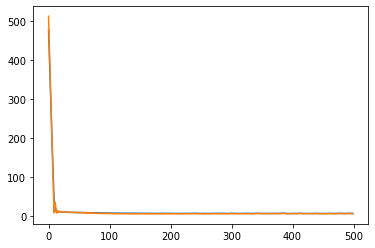

In [40]:
import matplotlib.pyplot as plt

# plot losses
plt.plot(avg_train)
plt.plot(avg_val)
plt.show()

What about with batch normalization?

  0%|          | 0/500 [00:00<?, ?it/s]

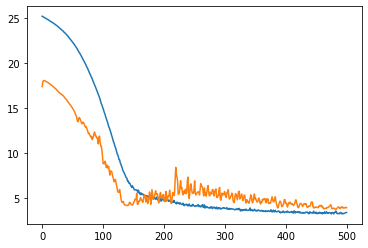

In [35]:
model = TwoLayerNN_BN(2, 10, 1)
lossFun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# collect losses
avg_train = []
avg_val = []

for epoch in tqdm(range(500)):
    train_losses = []
    for x, y in mpg_train_dl:
        
        model.train()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    avg_train.append(sum(train_losses) / len(train_losses))
    
    for x, y in mpg_val_dl:
        model.eval()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        
        avg_val.append(loss.item())
        
plt.plot(avg_train)
plt.plot(avg_val)
plt.show()

## Categorical Embeddings
- let's include the make of the car in our model

In [41]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [42]:
makes = []
for idx in range(len(mpg)):
    row = mpg.iloc[idx]
    makes.append(row['name'].split(' ')[0])
mpg['make'] = makes
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,make
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,buick
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,ford


In [43]:
# create an index for possible values of make
# sort of like a one-hot-encoding here
make_dict = {make: i for i, make in enumerate(set(makes))}
make_dict

{'amc': 0,
 'oldsmobile': 1,
 'saab': 2,
 'opel': 3,
 'datsun': 4,
 'renault': 5,
 'toyouta': 6,
 'chrysler': 7,
 'mercury': 8,
 'mercedes': 9,
 'audi': 10,
 'ford': 11,
 'peugeot': 12,
 'hi': 13,
 'bmw': 14,
 'subaru': 15,
 'chevy': 16,
 'vw': 17,
 'nissan': 18,
 'plymouth': 19,
 'chevrolet': 20,
 'mazda': 21,
 'toyota': 22,
 'volvo': 23,
 'mercedes-benz': 24,
 'pontiac': 25,
 'volkswagen': 26,
 'triumph': 27,
 'honda': 28,
 'capri': 29,
 'vokswagen': 30,
 'dodge': 31,
 'chevroelt': 32,
 'fiat': 33,
 'maxda': 34,
 'buick': 35,
 'cadillac': 36}

In [44]:
class MPGDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        make_idx = make_dict[row['make']]
        
        x1 = torch.tensor([row['displacement'],
                          row['weight']]).float()
        
        x2 = torch.tensor(make_idx)
        
        x3 = torch.tensor(mak)
        
        y = torch.tensor(row['mpg']).float()
        
        return x1, x2, y
    
mpg_ds = MPGDataset(mpg)

# note the second tensor
next(iter(mpg_ds))

(tensor([ 307., 3504.]), tensor(20), tensor(18.))

In [48]:
# let's add an embedding layer
class TwoLayerNN_Emb(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_Emb, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
        # first argument is number of values, next is size of embedding
        self.emb = nn.Embedding(len(make_dict), 2)
        
        # let's keep in batch normalization
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x1, x2):

        
        x2 = self.emb(x2)
        
        
        # concatenate the vectors along dim=1, skipping batch dim
        x = torch.cat((x1, x2), dim=1)
        
        x = self.linear1(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        
        return torch.squeeze(x)

In [49]:
mpg_dl = DataLoader(mpg_ds, batch_size=50, shuffle=True)

# what is the correct dimension here?
model = TwoLayerNN_Emb(4, 5, 1)
x1, x2, y = next(iter(mpg_dl))
model(x1, x2)

tensor([ 0.4788,  0.2368,  0.2059,  0.3057, -0.2356,  0.1618, -0.1477, -0.4667,
         0.1036,  0.4167, -0.0813,  0.1258, -0.6257,  0.1008, -0.6941, -0.6121,
         0.6068, -0.6140,  0.6242, -0.5120, -0.5991, -0.4716, -0.6042, -0.4462,
        -0.7228,  0.7131, -0.0314, -0.4247,  0.4395,  0.3977, -0.2793, -0.2509,
        -0.6100, -0.3572, -0.6174, -0.1574,  0.0409, -0.3811,  0.4278, -0.0436,
        -0.3390,  0.4005,  0.4078,  0.2464, -0.4576,  0.5385, -0.5042, -0.4754,
         0.0461, -0.1120], grad_fn=<SqueezeBackward0>)

Let's train it the same way we did above

In [50]:
# train/val split
mpg_train = mpg[100:].reset_index(drop=True)
mpg_val = mpg[:100].reset_index(drop=True)
mpg_train_ds = MPGDataset(mpg_train)
mpg_val_ds = MPGDataset(mpg_val)

# load into dataloader
mpg_train_dl = DataLoader(mpg_train_ds, batch_size=50, shuffle=True)
mpg_val_dl = DataLoader(mpg_val_ds, batch_size=100, shuffle=False)

In [51]:
lossFun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# collect losses
avg_train = []
avg_val = []

for epoch in tqdm(range(500)):
    train_losses = []
    for x1, x2, y in mpg_train_dl:
        
        model.train()
        
        y_pred = model(x1, x2)
        loss = lossFun(y_pred, y)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    avg_train.append(sum(train_losses) / len(train_losses))
    
    for x1, x2, y in mpg_val_dl:
        model.eval()
        
        y_pred = model(x1, x2)
        loss = lossFun(y_pred, y)
        
        avg_val.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

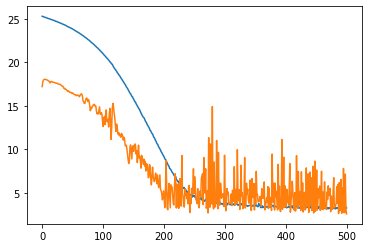

In [52]:
plt.plot(avg_train)
plt.plot(avg_val)
plt.show()

In [53]:
# let's look at the embedding matrix
for param in model.emb.parameters():
    print(param)

Parameter containing:
tensor([[ 2.8146,  1.9455],
        [ 0.6869, -2.8343],
        [-0.2157,  2.1363],
        [ 1.0552,  0.6774],
        [-1.3695,  0.9252],
        [-0.9622, -0.7758],
        [-1.4556, -0.5759],
        [-0.9830, -1.0059],
        [ 1.7811,  1.2739],
        [-2.3976, -0.0066],
        [-0.0082,  1.3837],
        [-1.4818,  1.2084],
        [ 1.2612,  1.9217],
        [-0.4952,  0.2546],
        [ 1.1660,  1.5533],
        [ 0.0968, -0.7482],
        [-0.9388, -0.9540],
        [-0.5662, -2.8878],
        [-3.1124, -0.0651],
        [-1.4413, -0.7437],
        [ 0.6598,  2.2356],
        [ 0.2823, -0.4011],
        [-1.2784,  1.4904],
        [ 0.7697,  1.1418],
        [ 0.4472, -0.6016],
        [-1.7330, -0.8606],
        [ 0.3117,  0.1247],
        [-0.8744, -1.0405],
        [ 0.6430, -1.9272],
        [-1.3654,  1.2484],
        [ 0.1985, -0.4045],
        [-0.9599, -1.4164],
        [-0.6707,  0.3185],
        [ 0.0280,  1.2643],
        [ 0.4538, -0.6800]

In [54]:
# compare embeddings for vw and volkswagon
for param in model.emb.parameters():
    print(param[26], param[30])

tensor([0.3117, 0.1247], grad_fn=<SelectBackward>) tensor([ 0.1985, -0.4045], grad_fn=<SelectBackward>)


## Training on a GPU
- We saw how slow it was to train images on a cpu
- PyTorch makes it easy to do this training on a GPU!
- Always follow GPU etiquette and check who is running what

In [46]:
# is a GPU available?
torch.cuda.is_available()

False

In [47]:
# check who is using what
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [48]:
# how many devices are there?
torch.cuda.device_count()

0

In [49]:
device_no = 0
if torch.cuda.is_available() == True:
    device = torch.device(device_no)
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [50]:
# move model parameters to device
model.to(device)

Tune_ResNet(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
# let's adapt our earlier function
def one_pass(model, dataloader, optimizer, lossFun, device, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        # send labelled data to the device
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

Note that
- The model can only take inputs on the same device
- The output is also on the specified device and cannot interact with tensors on a different device

In [ ]:
x, y = next(iter(dl_train))

# move to device
x, y = x.to(device), y.to(device)

# perform computation
y_pred = model(x)

# now its on the cpu again
y_pred.cpu()

In [ ]:
x.cuda()